In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import math
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import _LRScheduler
import warnings
import spacy
from scipy.io import savemat
import dill as pickle
import thop
from torch_challenge_dataset import DeepVerseChallengeLoaderTaskThree
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
onoffdict={'GPS': True, 'CAMERAS': True, 'RADAR': True}
lr=3e-3
num_epochs=50
reduction = 4
num_H = 64
weight_path=f'models/CSINettask3/cr{reduction}/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [3]:
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

In [4]:
batch_size=200
accumulation_steps = 2  # Set the number of gradient accumulation steps
effective_batch_size = batch_size // accumulation_steps  # Calculate the effective batch size


In [5]:
 # Task 3
train_dataset = DeepVerseChallengeLoaderTaskThree(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=4)
test_dataset = DeepVerseChallengeLoaderTaskThree(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=4)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Utils and Models

In [7]:
def CSI_abs_reshape(y, csi_std=2.8117975e-06, target_std=1.0):
    y = torch.abs(y)
    y=(y/csi_std)*target_std
    return y

In [8]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

In [9]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [10]:
def normalize_image(image):
    # Convert image to float tensor
    image = image.float()
    # Normalize the image
    image /= 255.0
    # ImageNet mean values # ImageNet standard deviation values
    trans=T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
    image=trans(image)
    return image

In [11]:
def left_coordinates_batch(x_cor, y_cor):
    y_pix = torch.zeros_like(x_cor)
    x_pix = torch.zeros_like(y_cor)

    condition1 = y_cor < -4
    condition2 = (y_cor >= -4) & (y_cor < -1)
    condition3 = (y_cor >= -1) & (y_cor < 1)
    condition4 = (y_cor >= 1) & (y_cor < 4)
    condition5 = y_cor >= 4

    y_pix[condition1] = 100 + (250 - 100) * ((x_cor[condition1] - 80) / (125 - 80))
    y_pix[condition2] = 100 + (250 - 100) * ((x_cor[condition2] - 80) / (125 - 80))
    y_pix[condition3] = 100 + (250 - 100) * ((x_cor[condition3] - 80) / (125 - 80))
    y_pix[condition4] = 100 + (210 - 100) * ((x_cor[condition4] - 80) / (125 - 80))
    y_pix[condition5] = 100 + (190 - 100) * ((x_cor[condition5] - 80) / (125 - 80))

    x_pix[condition1] = (y_pix[condition1] - 30) / 1.35
    x_pix[condition2] = (y_pix[condition2] - 45) / 0.85
    x_pix[condition3] = (y_pix[condition3] - 55) / 0.70
    x_pix[condition4] = (y_pix[condition4] - 65) / 0.60
    x_pix[condition5] = (y_pix[condition5] - 65) / 0.5
    return x_pix, y_pix

In [12]:
def center_coordinates_batch(x_cor, y_cor):
    x_pix = torch.zeros_like(x_cor)
    y_pix = torch.zeros_like(y_cor)

    condition = y_cor < 0
    x_pix[condition] = 256 * ((x_cor[condition] - 119) / (139 - 119))
    x_pix[~condition] = 256 * ((x_cor[~condition] - 112) / (146 - 113))
    
    y_pix = 175 + (100 - 175) * ((y_cor - (-7)) / ((7) - (-7)))
    return x_pix, y_pix

In [13]:
def right_coordinates_batch(x_cor, y_cor):
    y_pix = torch.zeros_like(x_cor)
    x_pix = torch.zeros_like(y_cor)

    condition1 = y_cor < -4
    condition2 = (y_cor >= -4) & (y_cor < -1)
    condition3 = (y_cor >= -1) & (y_cor < 1)
    condition4 = (y_cor >= 1) & (y_cor < 4)
    condition5 = y_cor >= 4

    y_pix[condition1] = 250 + (100 - 250) * ((x_cor[condition1] - 125) / (200 - 125))
    y_pix[condition2] = 250 + (100 - 250) * ((x_cor[condition2] - 125) / (200 - 125))
    y_pix[condition3] = 250 + (100 - 250) * ((x_cor[condition3] - 125) / (200 - 125))
    y_pix[condition4] = 210 + (100 - 210) * ((x_cor[condition4] - 125) / (200 - 125))
    y_pix[condition5] = 190 + (100 - 190) * ((x_cor[condition5] - 125) / (200 - 125))

    x_pix[condition1] = -(y_pix[condition1] - 370) / 1.25
    x_pix[condition2] = -(y_pix[condition2] - 285) / 0.87
    x_pix[condition3] = -(y_pix[condition3] - 250) / 0.73
    x_pix[condition4] = -(y_pix[condition4] - 210) / 0.55
    x_pix[condition5] = -(y_pix[condition5] - 190) / 0.45
    return x_pix, y_pix

In [14]:
def center_image_batch(images, center_x, center_y, output_size, bounded=False):
    batch_size = images.size(0)
    
    if bounded == 'left':
        top = torch.clamp(center_y - output_size[0] // 2, 0, None)
        left = torch.clamp(center_x - output_size[1] // 2, 0, None)
    elif bounded == 'right':
        bottom = center_y + output_size[0] // 2
        right = torch.clamp(center_x + output_size[1] // 2, None, 250)
        top = torch.clamp(bottom - output_size[0], 0, None)
        left = right - output_size[1]
    else:
        top = center_y - output_size[0] // 2
        left = center_x - output_size[1] // 2

    resize_transform = transforms.Resize((output_size))
    cropped_images = [TF.crop(image, int(top[i].item()), int(left[i].item()), output_size[0], output_size[1]) 
                        for i, image in enumerate(images)]
    cropped_images = torch.stack([resize_transform(image) for image in cropped_images])
    return cropped_images

In [15]:
def process_imgs(gps, img_1, img_2, img_3, crop_size = (150,150)):
    x_cor = gps[:,0]
    y_cor = gps[:,1]

    x_pix,y_pix = left_coordinates_batch(x_cor, y_cor)
    img_1 = center_image_batch(img_1, x_pix.to(torch.int), y_pix.to(torch.int), crop_size, 'left')

    x_pix,y_pix = center_coordinates_batch(x_cor, y_cor)
    img_2 = center_image_batch(img_2, x_pix.to(torch.int), y_pix.to(torch.int), crop_size)

    x_pix,y_pix = right_coordinates_batch(x_cor, y_cor)
    img_3 = center_image_batch(img_3, x_pix.to(torch.int), y_pix.to(torch.int), crop_size, 'right')

    return img_1, img_2, img_3

Scheduler

In [16]:
class gpsdata(nn.Module):
    def __init__(self):
        super().__init__()
        self.gps_fc = nn.Linear(2, 16)
        self.gps_relu = nn.ReLU()

    def forward(self, gps):  
        gps = gps.to(torch.float32)

        x, y = gps[:,0], gps[:,1]
        x_normd = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
        y_normd = (y - torch.min(y)) / (torch.max(y) - torch.min(y))
        gps_normd = torch.stack([x_normd,y_normd],dim=1)

        gps_out = self.gps_fc(gps_normd)  
        gps_out = self.gps_relu(gps_out)
        return gps_out

Radar Data Processing Layer

In [17]:
class radardata(nn.Module):
    
    def __init__(self):
        super(radardata, self).__init__()
        self.dropout = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.lr1=nn.LeakyReLU(negative_slope=0.3, inplace=True)
        self.encoder_fc = nn.Linear(256,16)
                
    def forward(self, x):
        x=x.view(-1,1,512,128)
        x = (x - 5.1838e-06) / (28.0494 - 5.1838e-06)
        out = self.pool1(self.dropout(self.conv1(x)))
        out = self.pool2(self.dropout(self.conv2(out))).view(x.size(0), -1)
        out = self.dropout(self.encoder_fc(out))
        out = self.lr1(out)
        return out 

Camera Data Processing Layers

In [18]:
class cameradata(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.lr1=nn.LeakyReLU(negative_slope=0.3, inplace=True)
        self.encoder = nn.Linear(1*81,16)
        self.dropout = nn.Dropout(0.5)

    def forward(self, cam):  
        cam = normalize_image(cam).to(torch.float32)
        out = self.pool1(self.dropout(self.conv1(cam)))
        out = self.pool2(self.dropout(self.conv2(out)))
        out = self.lr1(out).view(-1,1*81)
        out = self.dropout(self.encoder(out))
        return out

# Baseline model

In [19]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

In [20]:
class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.direct_path = nn.Sequential(OrderedDict([
            ("conv_1", ConvBN(2, 8, kernel_size=3)),
            ("conv_2", ConvBN(8, 16, kernel_size=3)),
            ("conv_3", nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)),
            ("bn", nn.BatchNorm2d(2))
        ]))
        self.identity = nn.Identity()
        self.relu = nn.LeakyReLU(negative_slope=0.3, inplace=True)
    def forward(self, x):
        identity = self.identity(x)
        out = self.direct_path(x)
        out = self.relu(out + identity)
        
        return out

In [21]:
class task2Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Encoder, self).__init__()
        self.total_size =8192
        n1=int(math.log2(reduction))
        self.encoder_convbn = ConvBN(1, 2, kernel_size=3)
        self.encoder_fc = nn.Linear(self.total_size, self.total_size // reduction)
       
        
                
        
    def forward(self, x):
        n, c, h, w = x.detach().size()
        out = self.encoder_convbn(x.to(torch.float32))
        out =  self.encoder_fc(out.view(n, -1))
        
        return out
       

In [22]:
class task2Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Decoder, self).__init__()
        self.total_size = 8192
        w, h =64, 64
        self.reduced_size = self.total_size//reduction
        self.decoder_fc = nn.Linear(self.total_size // reduction, self.total_size)
        
        self.decoder_RefineNet1 = ResBlock()
        self.decoder_RefineNet2 = ResBlock()
        self.decoder_conv = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1)
        self.decoder_bn = nn.BatchNorm2d(2)
        
        
        self.decoder_fc2 = nn.Linear(self.total_size, self.total_size//2)
        self.sig2 = nn.Sigmoid()
        
        
    
    def forward(self, Hencoded):
        bs = Hencoded.size(0)
        #combining
        out = Hencoded.view(bs, self.reduced_size)
        # Generate final output
        out = self.decoder_fc(out)
        
        out = out.view(bs, -1, 64, 64)
        out = self.decoder_RefineNet1(out)
        out = self.decoder_RefineNet2(out)
        out = self.decoder_conv(out)
        out = self.sig2(self.decoder_fc2(out.view(bs, -1)))
        
        return out.view(bs, -1, 64, 64)

In [23]:
class task3Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task3Encoder, self).__init__()
        

        #self.en=task2Encoder(reduction)
        #reduction value is already considered in the task2weight_path
        # loading preloaded values
        self.en=task2Encoder(reduction)
        self.allow_update = False  # Initially, do not allow weight updates
        
    def forward(self, x):
        # Reshape the parameters to match the batch size
        if self.allow_update:
            out = self.en(x)
        else:
            with torch.no_grad():
                out = self.en(x)
        
        encoded_features=out
        return encoded_features
       

In [24]:
class task3Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task3Decoder, self).__init__()
        self.total_size = 8192
        w, h =64, 64
        self.de = task2Decoder(reduction)
        
        #Layers for auto regression 
        self.a= nn.Parameter(torch.randn(self.total_size//2))
        self.b= nn.Parameter(torch.randn(self.total_size//2))
        self.c= nn.Parameter(torch.randn(self.total_size//2))
        self.d= nn.Parameter(torch.randn(self.total_size//2))
        self.allow_update = False  # Initially, do not allow weight updates
    
    
    
    def forward(self, Hencoded, input_autoregressive_features):
        bs = Hencoded.size(0)
        a = self.a.expand(bs, -1)
        b = self.b.expand(bs, -1)
        c = self.c.expand(bs, -1)
        d = self.d.expand(bs, -1)
        out_tminus1=input_autoregressive_features[:,0,:].view(bs,-1)
        out_tminus2=input_autoregressive_features[:,1,:].view(bs,-1)
        if self.allow_update:
            out_t = self.de(Hencoded)
        else:
            with torch.no_grad():
                out_t = self.de(Hencoded)
        #print(out_t.shape)
        out = (out_t.view(bs,-1)) * a + out_tminus1 * b + out_tminus2 * c + d
        
        autoregressive_features = out
        
        output = out.view(bs,1, 64, 64)
        
        return output, autoregressive_features
       

In [25]:
#loading weights of baseline model and task 1
onoffdictb={'GPS': False, 'CAMERAS': False, 'RADAR': False} #baseline dictionary

weight_pathb=f'models/CSINettask3/cr{reduction}/gps{onoffdictb["GPS"]}_cam{onoffdictb["CAMERAS"]}_rad{onoffdictb["RADAR"]}/'

In [26]:
task1_weight_path=f'models/task1/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [27]:
class task1decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.gp = gpsdata()
        self.rd = radardata()
        self.lc = cameradata()
        self.cc = cameradata()
        self.rc = cameradata()

        if int(num_H/2)*int(num_H/2) > 32:
            self.linear = nn.Linear(16*5, int(num_H/2)*int(num_H/2))
            self.output_fc = nn.Linear(int(num_H/2)*int(num_H/2), num_H*num_H)
            self.output_relu = nn.ReLU()
        else:
            self.linear = nn.Linear(16*5, 32)
            self.output_fc = nn.Linear(32, num_H*num_H)
            self.output_relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self,gps,radar,left_cam,center_cam,right_cam,onoffdict):
        bs = gps.size(0)
        
        if onoffdict['GPS']:
             gps_out = self.gp(gps)
        else:
             gps_out = torch.zeros(bs, 16).to(device)
        
        if onoffdict['RADAR']:
            radar_out = self.rd(radar)
        else:
            radar_out = torch.zeros(bs, 16).to(device)
        
        if onoffdict['CAMERAS']:
            left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
            lc_out = self.lc(left_cam)
            cc_out = self.cc(center_cam)
            rc_out = self.rc(right_cam)
        else:
            lc_out = torch.zeros(bs, 16).to(device)
            cc_out = torch.zeros(bs, 16).to(device)
            rc_out = torch.zeros(bs, 16).to(device)

        combined = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)
        
        output = self.linear(combined)
        output = self.output_relu(output)
        output = self.output_fc(output)
        output = self.output_relu(output)
        output = output.view(output.size(0), 1, num_H, num_H)

        return output

In [28]:
class Decoderwithmsi(nn.Module):
    def __init__(self, reduction):
        super().__init__()
        self.task1decoder = torch.load(task1_weight_path+"task1Decoder.pth")
        self.gp = self.task1decoder.gp
        self.rd = self.task1decoder.rd
        self.lc = self.task1decoder.lc
        self.cc = self.task1decoder.cc
        self.rc = self.task1decoder.rc
        self.bde = torch.load(weight_pathb+"task3Decoder.pth")
        self.allow_update = False  # Initially, do not allow weight updates
        #self.bde = baselinedecoder(reduction) 

        if int(num_H/2)*int(num_H/2) > 32:
            self.linear = self.task1decoder.linear
            self.output_fc1= nn.Linear(int(num_H/2)*int(num_H/2)+num_H*num_H, 2*num_H*num_H)
            self.output_fc2 = nn.Linear(2*num_H*num_H, num_H*num_H)
            self.output_relu = nn.ReLU()
        else:
            self.linear = self.task1decoder.linear
            self.output_fc1 = nn.Linear(32+num_H*num_H, 2*num_H*num_H)
            self.output_fc2 = nn.Linear(2*num_H*num_H, num_H*num_H)
            self.output_relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, Hencoded,gps,radar,left_cam,center_cam,right_cam,onoffdict, input_autoregressive_features):
        bs = Hencoded.size(0)
        if self.allow_update:
            Hdecoded, _ =self.bde(Hencoded, input_autoregressive_features)
            if onoffdict['GPS']:
                 gps_out = self.gp(gps)
            else:
                 gps_out = torch.zeros(bs, 16).to(device)

            if onoffdict['RADAR']:
                radar_out = self.rd(radar)
            else:
                radar_out = torch.zeros(bs, 16).to(device)

            if onoffdict['CAMERAS']:
                left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
                lc_out = self.lc(left_cam)
                cc_out = self.cc(center_cam)
                rc_out = self.rc(right_cam)
            else:
                lc_out = torch.zeros(bs, 16).to(device)
                cc_out = torch.zeros(bs, 16).to(device)
                rc_out = torch.zeros(bs, 16).to(device)

            combined1 = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)

            output = self.linear(combined1)
        else:
            with torch.no_grad():
                Hdecoded, _ =self.bde(Hencoded, input_autoregressive_features)
                if onoffdict['GPS']:
                     gps_out = self.gp(gps)
                else:
                     gps_out = torch.zeros(bs, 16).to(device)

                if onoffdict['RADAR']:
                    radar_out = self.rd(radar)
                else:
                    radar_out = torch.zeros(bs, 16).to(device)

                if onoffdict['CAMERAS']:
                    left_cam, center_cam, right_cam = process_imgs(gps, left_cam, center_cam, right_cam, crop_size = (150,150))
                    lc_out = self.lc(left_cam)
                    cc_out = self.cc(center_cam)
                    rc_out = self.rc(right_cam)
                else:
                    lc_out = torch.zeros(bs, 16).to(device)
                    cc_out = torch.zeros(bs, 16).to(device)
                    rc_out = torch.zeros(bs, 16).to(device)

                combined1 = torch.cat((gps_out, radar_out, lc_out, cc_out, rc_out), dim=1)

                output = self.linear(combined1)
                
        
        
        
        output = self.output_relu(output)
        combined2 = torch.cat((output, Hdecoded.view(bs,-1)), dim=1)
        output = self.output_fc1(combined2)
        output = self.output_relu(output)
        output = self.output_fc2(output)
        
        autoregressive_features = output
        #print(output.shape)
        output = output.view(bs, 1, num_H, num_H)

        return output, autoregressive_features

In [29]:
#complete task 3 model including encoder, decoder and channel
class task3model(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        self.total_size = 8192
        self.reduced_size = self.total_size//reduction
        self.en = torch.load(weight_pathb+"task3Encoder.pth")
        self.de = Decoderwithmsi(reduction)
        self.ar = [None] * 5  # List to store the AR variables
    
    
    
    def forward(self, Hin, gps, radar, left_cam, center_cam, right_cam, time_index, device, is_training, onoffdict): 
         
       
        batch_size = Hin.shape[0]
        Hencoded = self.en(Hin)
        
        Hreceived = Hencoded
            
        # Encoder
        if time_index == 0:
            iarf = torch.zeros((batch_size, 2, self.total_size//2), dtype=torch.float).to(device)
            Hdecoded, self.ar[0] = self.de(Hencoded, gps, radar, left_cam, center_cam, right_cam, onoffdict, iarf)
    
        elif time_index==1:
            iarf=torch.cat([self.ar[0].view(batch_size, 1, self.total_size//2).detach(), torch.zeros((batch_size, 1, self.total_size//2), dtype=torch.float).to(device)], dim=1)
            Hdecoded, self.ar[1] = self.de(Hencoded, gps, radar, left_cam, center_cam, right_cam, onoffdict, iarf)
            
        else:
            iarf = torch.cat([self.ar[time_index-1].view(batch_size, 1, self.total_size//2).detach(), self.ar[time_index-2].view(batch_size, 1, self.total_size//2).detach()], dim=1)
            Hdecoded, self.ar[time_index] = self.de(Hencoded, gps, radar, left_cam, center_cam, right_cam, onoffdict, iarf)

        return Hdecoded


In [30]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

In [31]:
model=task3model(reduction)

In [32]:

print(f'Number of parameters in Task3 Encoder: {cal_model_parameters(model.en)}')
print(f'Number of parameters in Task3 Decoder: {cal_model_parameters(model.de)}')

Number of parameters in Task3 Encoder: 16779286
Number of parameters in Task3 Decoder: 130163622


In [33]:
# Training

In [34]:
# Check if "models" folder exists, create it if it doesn't
if not os.path.exists("models"):
    os.makedirs("models")


In [35]:
#Loss

#criterion=nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss().to(device)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#if SGDR == True:
#    sched = CosineWithRestarts(optimizer, T_max=n_batches)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, threshold=0.00001, patience=200, verbose=True)

In [37]:
scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                            T_max=num_epochs,
                                            T_warmup=10 ,
                                            eta_min=1e-5)

In [38]:
model = model.to(device)


In [39]:
model.de.allow_update

False

In [40]:
model.de.bde.allow_update=False

In [41]:
model.de.bde.allow_update

False

In [42]:
model.en.allow_update=False
model.en.allow_update

False

In [43]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []
train_nmses = []
val_nmses = []
patience_counter = 0
best_val_loss = float('inf')

for i in range(num_epochs):
    loss1 = 0
    nmse1 = 0
    epoch_time = time.time()
    model.train()
    optimizer.zero_grad()
    if i >= 10: #update model weights after 40 epochs
        model.en.allow_update = True
        model.de.allow_update = True
        model.de.bde.allow_update = True
    # Run the training batches
    
    for b, t_x in enumerate(train_loader):
        model.ar = [None] * 5  
        for time_index, (X, y) in enumerate(t_x):
            
            y_train_reshaped = CSI_abs_reshape(y.to(device))
            Xin = CSI_abs_reshape(X[0].to(device))
            # Get the input and output for the given time index
            y_pred = model(Xin, X[1].to(device),X[2].to(device),X[3].to(device),X[4].to(device),X[5].to(device), time_index, device, is_training=True, onoffdict = onoffdict)
            
            loss = criterion(y_pred, y_train_reshaped)
            loss1 += loss.item()
            loss.backward()
            
        
        if (b + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
    train_loss = loss1 / (num_train_batches * 5)
    train_losses.append(train_loss)
    # Update the learning rate scheduler
    scheduler.step()
    
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        loss1 = 0
        nmse1 = 0
        for b, t_x in enumerate(test_loader):
            model.ar = [None] * 5 
            for time_index, (X, y) in enumerate(t_x):
            
                y_test_reshaped = CSI_abs_reshape(y.to(device))
                Xin = CSI_abs_reshape(X[0].to(device))
                # Get the input and output for the given time index
                y_pred = model(Xin, X[1].to(device),X[2].to(device),X[3].to(device),X[4].to(device), X[5].to(device), time_index, device, is_training=True, onoffdict = onoffdict)
                
                loss = criterion(y_pred, y_test_reshaped)
                loss1 += loss.item() 
                
        val_loss = loss1 / (num_test_batches * 5)
        val_losses.append(val_loss)
        
    
    print(f'epoch:{i+1}/{num_epochs} average reshaped TL:{train_loss:10.8f} average reshaped VL:{val_loss:10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, weight_path + "task3.pth")
        torch.save(model.en, weight_path + "task3Encoder.pth")
        torch.save(model.de, weight_path + "task3Decoder.pth")
        
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/50 average reshaped TL:2.49731968 average reshaped VL:2.58708847 epoch time:2520 seconds, lr:3.00e-04
epoch:2/50 average reshaped TL:0.69168499 average reshaped VL:0.44986120 epoch time:2690 seconds, lr:6.00e-04
epoch:3/50 average reshaped TL:0.38210823 average reshaped VL:0.43950255 epoch time:2660 seconds, lr:9.00e-04
epoch:4/50 average reshaped TL:0.36256129 average reshaped VL:0.44692142 epoch time:2593 seconds, lr:1.20e-03
epoch:5/50 average reshaped TL:0.37992017 average reshaped VL:0.56312589 epoch time:2579 seconds, lr:1.50e-03
epoch:6/50 average reshaped TL:0.37373451 average reshaped VL:0.44205014 epoch time:2612 seconds, lr:1.80e-03
epoch:7/50 average reshaped TL:0.35723613 average reshaped VL:0.48067324 epoch time:2713 seconds, lr:2.10e-03
epoch:8/50 average reshaped TL:0.34522323 average reshaped VL:0.49666339 epoch time:2638 seconds, lr:2.40e-03
epoch:9/50 average reshaped TL:0.38109045 average reshaped VL:0.58237528 epoch time:2560 seconds, lr:2.70e-03
epoch:10/5

In [44]:
np.save(weight_path+'train_loss.npy', train_losses)
np.save(weight_path+'val_loss.npy', val_losses)

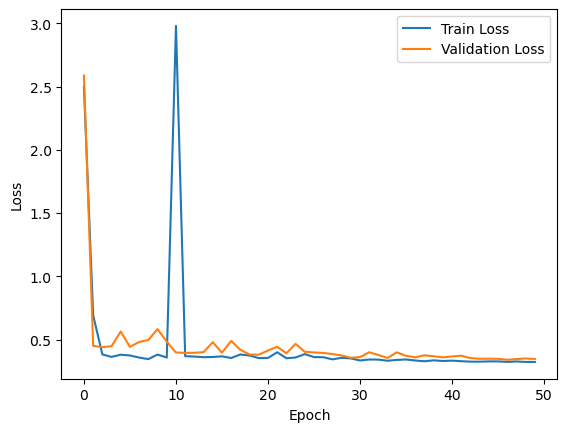

In [45]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inference

In [46]:
model2=torch.load(weight_path + "task3.pth").to(device)
# Run the testing batches
model2.eval()
with torch.no_grad():
    mse1=0
    nmse1 = 0
    for b,t_x in enumerate(test_loader):
        model2.ar = [None] * 5 
        for time_index,(X, y) in enumerate(t_x):
            y_test_reshaped = CSI_abs_reshape(y.to(device))
            Xin = CSI_abs_reshape(X[0].to(device))
            # Get the input and output for the given time index
            y_pred = model2(Xin,X[1].to(device),X[2].to(device),X[3].to(device),X[4].to(device),X[5].to(device), time_index, device, is_training=True, onoffdict = onoffdict)
                
            mse0 = criterion(y_pred, y_test_reshaped) 
            mse1+=mse0  
            
    avg_mse=mse1/(5*num_test_batches)
    

In [47]:
print(f'Average MSE:{avg_mse}')


Average MSE:0.34190472960472107


In [48]:
dict={'train_losses':train_losses, 'val_losses': val_losses, 'test_mse': avg_mse.item() }
savemat(weight_path+'losses.mat', dict)
with open(weight_path+'losses.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict, file)

In [49]:
h_list = torch.tensor([])
for b,t_x in enumerate(test_loader):
        for time_index,(X, y) in enumerate(t_x):
            h = CSI_abs_reshape(y)
            h_list = torch.cat([h_list,h])
target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

In [50]:
target_loss

tensor(1.1287)

In [51]:
improvement = (target_loss.item() - avg_mse) / target_loss.item() * 100
print(f'Percentage Improvement Achieved: {improvement:.4f}%')

Percentage Improvement Achieved: 69.7089%
